# Bussines Inteligence Lecture #5: Time Series Analysis
Data table is online and updates every day.

For analysis was taken covid-19 data form Czech Republic about total and new death & cases.


Firstly let's import all nedeed packages

In [1]:
import math
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
#default plot settings
sns.set(rc={'figure.figsize':(16, 9)})

Here we will upload our data table and set the indexing to time, so that means we will recieve a time series table

In [2]:
#Covid table upload with newest data
covid_table = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
#Indexing -> creating time series
covid_table['date'] = pd.to_datetime(covid_table['date'])
covid_table = covid_table.set_index('date')
print(covid_table.index)

DatetimeIndex(['2020-03-13', '2020-03-19', '2020-03-20', '2020-03-21',
               '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-27',
               ...
               '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06',
               '2020-11-07', '2020-11-08', '2020-11-09', '2020-11-10',
               '2020-11-11', '2020-11-12'],
              dtype='datetime64[ns]', name='date', length=56321, freq=None)


Let's make specific table for data from Czech Republic

In [3]:
#Force table to Czech Republic
covid_talble_cz = covid_table.loc[covid_table['location'] == 'Czech Republic']
used_columns = ['total_cases','new_cases','total_deaths', 'new_deaths']
covid_talble_cz = covid_talble_cz[used_columns]
covid_talble_cz = covid_talble_cz.fillna(0)
print(covid_talble_cz.head())


            total_cases  new_cases  total_deaths  new_deaths
date                                                        
2019-12-31          0.0        0.0           0.0         0.0
2020-01-01          0.0        0.0           0.0         0.0
2020-01-02          0.0        0.0           0.0         0.0
2020-01-03          0.0        0.0           0.0         0.0
2020-01-04          0.0        0.0           0.0         0.0


Next secton is for data visualizing of our data via plots and bars

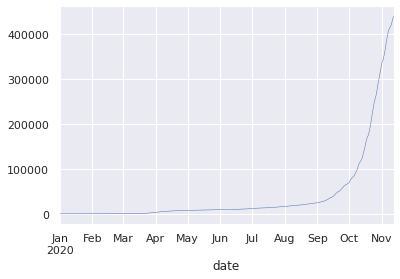

In [4]:
#Total cases plot
covid_talble_cz['total_cases'].plot(linewidth=0.5);

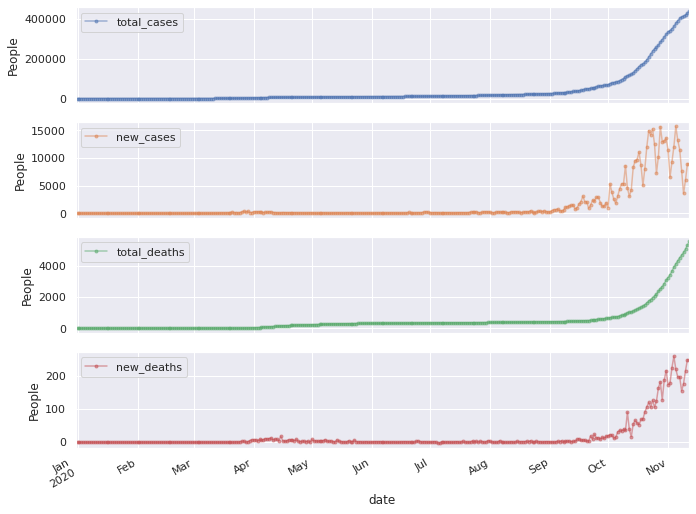

In [5]:
#Other plots
axes = covid_talble_cz[used_columns].plot(marker='.', linestyle='-', alpha=0.5, figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('People')

            total_cases   new_cases  total_deaths  new_deaths
date                                                         
2019-12-31     0.000000    0.000000      0.000000    0.000000
2020-01-31     0.000000    0.000000      0.000000    0.000000
2020-02-29     0.000000    0.000000      0.000000    0.000000
2020-03-31   750.387097   96.838710      2.580645    0.774194
2020-04-30  6003.833333  152.566667    146.266667    6.766667


Text(0.5, 1.0, 'Monthly mean of new cases')

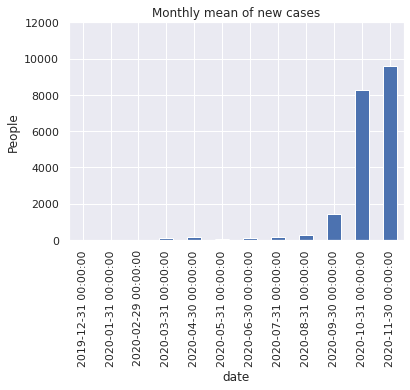

In [6]:
#Mothly mean table
covid_talble_cz_monthly_mean = covid_talble_cz[used_columns].resample('M').mean()
print(covid_talble_cz_monthly_mean.head())

#Monthly mean of new cases bar
monthly_cases_plot = covid_talble_cz_monthly_mean['new_cases'].plot.bar()
monthly_cases_plot.set_ylabel('People')
monthly_cases_plot.set_ylim(0, 12000)
monthly_cases_plot.set_title('Monthly mean of new cases')


Text(0.5, 1.0, 'Monthly mean of new deaths')

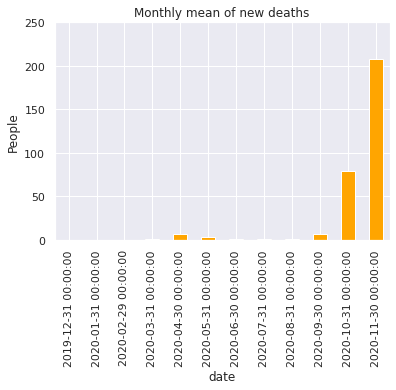

In [7]:
#Monthly mean of new deaths bar
monthly_deaths_plot = covid_talble_cz_monthly_mean['new_deaths'].plot.bar(color='orange')
monthly_deaths_plot.set_ylabel('People')
monthly_deaths_plot.set_ylim(0, 250)
monthly_deaths_plot.set_title('Monthly mean of new deaths')


This section contains LSTM Recurent Neural Netwrok that will be used for forecasting monthly mean of new deaths and cases. This code is mostly copy-paste form [this tutorial](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/). The data was separated to train and test data. Mostly it's separated on 70% and 30% respectively, but in our case we have completely different behavior at the start and in the end. Morover because lack of data our prediction is not as good as we would it like to be.

221 96
Epoch 1/20
219/219 - 0s - loss: 1.1034e-04
Epoch 2/20
219/219 - 0s - loss: 9.7092e-05
Epoch 3/20
219/219 - 0s - loss: 9.2266e-05
Epoch 4/20
219/219 - 0s - loss: 8.5781e-05
Epoch 5/20
219/219 - 0s - loss: 8.1044e-05
Epoch 6/20
219/219 - 0s - loss: 8.1054e-05
Epoch 7/20
219/219 - 0s - loss: 7.9312e-05
Epoch 8/20
219/219 - 0s - loss: 7.3709e-05
Epoch 9/20
219/219 - 0s - loss: 7.5613e-05
Epoch 10/20
219/219 - 0s - loss: 7.3637e-05
Epoch 11/20
219/219 - 0s - loss: 6.9456e-05
Epoch 12/20
219/219 - 0s - loss: 7.2938e-05
Epoch 13/20
219/219 - 0s - loss: 7.0930e-05
Epoch 14/20
219/219 - 0s - loss: 7.5581e-05
Epoch 15/20
219/219 - 0s - loss: 6.9555e-05
Epoch 16/20
219/219 - 0s - loss: 7.3887e-05
Epoch 17/20
219/219 - 0s - loss: 7.1115e-05
Epoch 18/20
219/219 - 0s - loss: 7.2052e-05
Epoch 19/20
219/219 - 0s - loss: 7.0928e-05
Epoch 20/20
219/219 - 0s - loss: 6.9388e-05


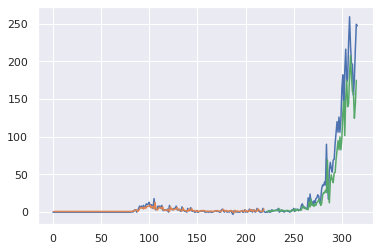

In [8]:
#Monthly mean new cases & new dearhs forecast with LSTM Recurent Neural Network
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

dataset_full = covid_talble_cz.loc['2020-1':'2020']
#dataset = dataset_full[['new_cases']] 
dataset = dataset_full[['new_deaths']]
dataset = dataset.values

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
 
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()